**Necessary libraries and modules**

In [19]:
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

**1. Data set**

In [24]:
# Defines the batch size which is used several times troughout the notebook. 
batch_size = 100

# Function to convert the string tensor into a usable tensor that contains the one-hot-encoded sequence (4 digits for each letter (250 letters per input) -> all in all 1000 input neurons).
def onehotify(tensor):
  vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'0'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
  split = tf.strings.bytes_split(tensor)
  labels = tf.cast(tf.strings.to_number(split), tf.uint8)                            #DO IT YOURSELF FOR OUTSTANDING?????
  onehot = tf.one_hot(labels, 4)
  onehot = tf.reshape(onehot, (-1,))
  return onehot

# Loads training and test data and saves it in two seperate TF Datasets (which have a 2-tuple structure (input, target)).
training_data, test_data = tfds.load('genomics_ood', split = ['train[:100000]', 'test[:1000]'], as_supervised = True)

# Handles the data. Provides separated datasets for inputs and targets each.
training_dataset_inputs = training_data.map(lambda inputs, targets: onehotify(inputs))
training_dataset_targets = training_data.map(lambda inputs, targets: tf.one_hot(targets, 10))

test_dataset_inputs = test_data.map(lambda inputs, targets: onehotify(inputs))
test_dataset_targets = test_data.map(lambda inputs, targets: tf.one_hot(targets, 10))

# Zips together inputs and labels for training- and test dataset. Afterwards Batching and prefetching is conducted.
training_dataset = tf.data.Dataset.zip((training_dataset_inputs, training_dataset_targets))
training_dataset = training_dataset.batch(batch_size).prefetch(2)

test_dataset = tf.data.Dataset.zip((test_dataset_inputs, test_dataset_targets))
test_dataset = test_dataset.batch(batch_size).prefetch(2)      

**2. Model**

In [25]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

# Class of the MLP.
class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid)
        self.output_layer = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)

    # Function to define a forward step (with python decorator).
    @tf.function
    def call(self, input):
        activ_hidden_1 = self.hidden_layer_1(input)
        activ_hidden_2 = self.hidden_layer_2(activ_hidden_1)
        prediction = self.output_layer(activ_hidden_2)
        return prediction

**3. Training**

In [26]:
# Function to conduct a forward step including backpropagation.
def training_step(mlp, training_data, loss_fn, optimizer):
  training_losses = []
  training_accuracies = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      prediction = mlp(input)
      current_training_loss = loss_fn(target, prediction)
      gradients = tape.gradient(current_training_loss, mlp.trainable_variables)
      optimizer.apply_gradients(zip(gradients, mlp.trainable_variables))

    training_losses.append(current_training_loss)

    current_training_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    training_accuracies.append(current_training_accuracy)   
  
  training_loss = np.mean(training_losses)
  training_accuracy = np.mean(training_accuracies)
  return training_loss, training_accuracy

# Function to determine the test loss and accuracy.
def test(mlp, test_data, loss_fn):
  test_losses = []
  test_accuracies = []

  for (input, target) in test_data:
    prediction = mlp(input)
    
    current_test_loss = loss_fn(target, prediction)
    test_losses.append(current_test_loss)

    current_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    test_accuracies.append(current_test_accuracy)   
    
  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)
  return test_loss, test_accuracy

In [27]:
tf.keras.backend.clear_session()

# Important parameters to train the MLP.
n_epochs = 10
learning_rate = 0.1

# Initialization of the MLP, the loss function and the optimizer.
mlp = Model()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialization of the lists which save data for visualization.
training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

# Training and testing loop.
for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))

    #Shuffles the datasets for each epoch to ensure that the order of inputs is always changed.
    training_dataset = training_dataset.shuffle(buffer_size = batch_size)
    test_dataset = test_dataset.shuffle(buffer_size = batch_size)

    #Training
    training_loss, training_accuracy = training_step(mlp, training_dataset, loss_fn, optimizer)
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    #Test
    test_loss, test_accuracy = test(mlp, test_dataset, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


**4. Visualization**

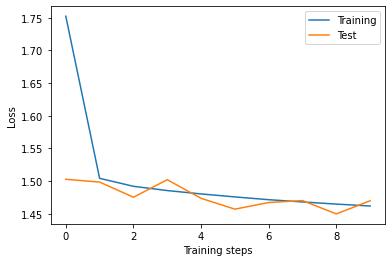

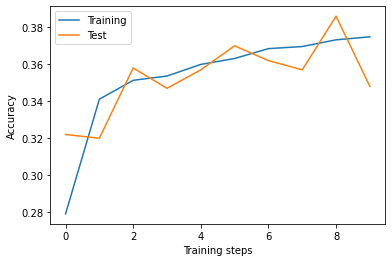

In [28]:
# Visualizes accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()

plt.figure()
line1, = plt.plot(training_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1, line2),("Training", "Test"))
plt.show()